# Pandas & BeautifulSoup 

**TLDR;**

- In this notebook we are going to see how we can combine two highly useful Python libraries: `pandas` and Beautifulsoup (BS).
- To demonstrate this, we will write a Python program that **compute statistics** about the **frequency of names** found in a small set of EpiDoc TEI/XML documents.

## Imports

In [3]:
import os
import pandas as pd
import bs4
from bs4 import BeautifulSoup

/Users/matteo/.pyenv/versions/3.6.8/envs/sunoikisis2020/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## BeautifulSoup: a quick introduction

There are several Python libraries to parse XML but `BeautifulSoup` is somehow the swiss knife of XML parsing.

It can parse HTML, XML, as well as ill-formed or broken XML documents (very useful for legacy XML or even SGML data).

### Open an XML file with BS

In [10]:
data_folder = 'data/'

# let's get the path of XML files
# we filter only files with XML extension
# it can be useful to ignore e.g. `.DS_Store` files (under MacOS)

xml_files = [
    os.path.join(data_folder, file)
    for file in os.listdir(data_folder)
    if ".xml" in file
]

In [24]:
with open(xml_files[0], 'r') as inpfile:
    xml_doc = BeautifulSoup(inpfile)

In [25]:
xml_files[0]

'data/igcyr024200.xml'

In [26]:
xml_doc

<?xml version="1.0" encoding="UTF-8"?><?xml-model href="http://www.stoa.org/epidoc/schema/8.23/tei-epidoc.rng" schematypens="http://relaxng.org/ns/structure/1.0"?><?xml-model href="http://www.stoa.org/epidoc/schema/8.23/tei-epidoc.rng" schematypens="http://purl.oclc.org/dsdl/schematron"?><html><body><tei xml:lang="en" xmlns="http://www.tei-c.org/ns/1.0">
<teiheader>
<filedesc>
<titlestmt>
<title><rs cert="low" type="textType">Private honors</rs> or <rs cert="low" type="textType">epitaph</rs></title>
<editor>Inscriptions of Greek Cyrenaica</editor>
</titlestmt>
<publicationstmt>
<authority></authority>
<idno type="filename">IGCyr024200</idno>
<availability>
<p><ref target="https://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attributions-NonCommercial 4.0 International</ref> License.</p> <p>All citation, reuse or distribution of this work must contain a link back to DOI: <ref target="http://doi.org/10.6092/UNIBO/IGCYRGVCYR">http://doi.org/10.6092/UNIBO/IGCYRGVCYR</ref> and 

### Finding elements by id

In [6]:
target_element = xml_doc.find_all(
    attrs={'xml:id': 'representation'}
)

In [7]:
target_element

[<category xml:id="representation"><catdesc>Digitized other representations</catdesc></category>]

In [8]:
# by definition, there should exist excatly one element
# with a given ID within the same document
assert len(target_element) == 1

### Finding elements by other attributes

The same search logic applies to any XML attribute.

Here we search for all `<name>` with `@type = patronymic`:

In [27]:
xml_doc.find_all(
    'name',
    attrs={'type': 'patronymic'}
)

[<name nymref="#Πρατομήδης" type="patronymic">Πρατομήδευς</name>]

### Finding elements by name

In [28]:
xml_doc.find_all(
    'persname'
)

[<persname key="" type="attested"><name nymref="#Ξεναρίστα">Ξεναρίστα</name>
 <persname key="" type="attested"><name nymref="#Πρατομήδης" type="patronymic">Πρατομήδευς</name></persname></persname>,
 <persname key="" type="attested"><name nymref="#Πρατομήδης" type="patronymic">Πρατομήδευς</name></persname>]

In [29]:
xml_doc.find_all(
    'bibl'
)

[<bibl><ptr target="#oliverioDAI2"></ptr>Oliverio in DAI 2,  p. 111, n. <citedrange>86</citedrange>, fig. 42</bibl>,
 <bibl><title>SEG</title>, <citedrange>9.198</citedrange></bibl>,
 <bibl><ptr target="#beschi1970"></ptr>Beshi 1970, p. <citedrange>204</citedrange> (date of the base)</bibl>,
 <bibl><ptr target="#dthorn-thorn2009"></ptr>D. &amp; J. Thorn, p. <citedrange>139</citedrange></bibl>]

### Navigating the XML tree

So far we have seen how to process all elements matching a given query, no matter where they are found in the document. But in other cases, it's desirable to navigate through the hierarchical structure of a document.

Let's navigate a bit the `edition` section of an EpiDoc TEI file. 

First off, we isolate this element, contained in a `<div>` with `@type=edition`:

In [9]:
edition = xml_doc.find_all(
    'div',
    attrs={'type': 'edition'}
)[0]

In [10]:
for child in edition.children:
    print(f"Element type: {type(child)}, element name: {child.name}, element content: \'{child}\'")

Element type: <class 'bs4.element.NavigableString'>, element name: None, element content: '
'
Element type: <class 'bs4.element.Tag'>, element name: ab, element content: '<ab>
<lb n="0"></lb><gap extent="unknown" reason="lost" unit="line"></gap>
<lb n="1"></lb><gap extent="unknown" reason="lost" unit="character"></gap> <persname type="attested"><name><seg part="F">μαχ
                    <lb break="no" n="2"></lb><supplied reason="lost">ο</supplied>ς</seg></name></persname>
</ab>'
Element type: <class 'bs4.element.NavigableString'>, element name: None, element content: '
'


In [11]:
for i, persname in enumerate(edition.find_all('name')):
    # note that element name and attribute name get lowercased
    print(i + 1, persname.text.replace('\n', ' '), persname.get('nymref'))

1 μαχ                     ος None


In [12]:
type(persname)

bs4.element.Tag

## XML data → `DataFrame`

**Why?**

When working with data, it's often very useful to compute some statistics about them. If you are working with a corpus of texts encoded it TEI/XML, you'll have to extract information from the XML files to be able to compute the stats.

**How?**

To do this, we combine together the two libraries we've encountered in this session: `pandas` and `BeautifulSoup`.

### Easy version

We want to parse all EpiDoc files contained in `data/` and extract all names (`<name>`). 

For each name we retain the following information:
- surface form (the textual content of the XML element)
- identifier (contained in `@nymRef`)
- type (contained in `@type`)

#### Function definitions

To avoid that the notebook becomes too messy, each step of the program is wrapped into a function.

These are the functions we will need:

In [20]:
# don't worry about this, it's just to add the type hints
# to each function declaration
from typing import List


def fetch_input_filenames(data_folder):
    # let's get the path of XML files
    # we filter only files with XML extension
    # it can be useful to ignore e.g. `.DS_Store` files (under MacOS)

    return [
        os.path.join(data_folder, file)
        for file in os.listdir(data_folder)
        if ".xml" in file
    ]

def read_xml(path) -> BeautifulSoup:
    """Reads the input XML file into a `BeautifulSoup` document."""
    with open(path, 'r') as inpfile:
        return BeautifulSoup(inpfile)
    
def find_name_element(doc: BeautifulSoup) -> List:
    """Extracts all `<name>` elements from an XML document."""
    return doc.find_all('name')


def parse_name_element(element: bs4.element.Tag) -> dict:
    """Transforms a `<name>` element into a dictionary."""
    assert element.name == 'name'
    return {
        "surface": element.text,
        "id": element.get('nymref'),
        "type": element.get('type')
    }

At this point, we are ready to do the following:
- we iterate through all the files in the directory `data/*.xml` (`line 3`)
- for each file, we iterate through its `<name>` element
- for each of these elements, we parse some information out of it and store it in a dictionary
- finally, all these new dictionaries are stored in a list.

This type of syntax construct in Python is called **list comprehension**. It's very powerful (yet a bit scary at first) as it allows for writing complex sequences of processing steps in a very compact fashion.

In [23]:
names = [
    parse_name_element(name)
    for file in fetch_input_filenames('data/')
    for name in find_name_element(read_xml(file))
]

In [22]:
len(names)

33

In [15]:
names_df = pd.DataFrame(names).set_index('id', drop=False)

In [16]:
names_df.head()

,surface,id,type
id,,,
#Ξεναρίστα,Ξεναρίστα,#Ξεναρίστα,None
#Πρατομήδης,Πρατομήδευς,#Πρατομήδης,patronymic
Ἰσαάκιος,Ἰσαάκου,Ἰσαάκιος,None
Ἰσαάκιος,Ἰσακίου,Ἰσαάκιος,None
Κομνηνός,Κομνηνοῦ,Κομνηνός,surname


### Advanced version

We want to extract all names from the TEI files while keeping the provenance of each name (i.e. the path of the file where it was found).

The logic is the same as in the code above, except for `line 2`. Instead of throwing all the names together, we create a tuple containing as the first element the file path, and as the second element the list of names it contains.

In [31]:
names = [
    (file, parse_name_element(name))
    for file in fetch_input_filenames('data/')
    for name in find_name_element(read_xml(file))
]

At this point, we need to *inject* the filename information into each name, before creating the dataframe.

We do this in two steps:
1. we create a list of dataframes, one per file (containing all names + the file path)
2. we concatenate all the dataframes in the list into a new one.

In [32]:
dfs = []

for file, name_elements in names:
    df = pd.DataFrame([name_elements]).set_index('id', drop=False)
    df['file'] = file
    dfs.append(df)

In [33]:
names_df = pd.concat(dfs)

In [34]:
names_df.shape

(33, 4)

In [35]:
names_df.head()

,surface,id,type,file
id,,,,
#Ξεναρίστα,Ξεναρίστα,#Ξεναρίστα,None,data/igcyr024200.xml
#Πρατομήδης,Πρατομήδευς,#Πρατομήδης,patronymic,data/igcyr024200.xml
Ἰσαάκιος,Ἰσαάκου,Ἰσαάκιος,None,data/iospe-5.14.xml
Ἰσαάκιος,Ἰσακίου,Ἰσαάκιος,None,data/iospe-5.11.xml
Κομνηνός,Κομνηνοῦ,Κομνηνός,surname,data/iospe-5.11.xml


## Data exploration

Let's see now how `pandas` can be used to explore this data. 

Think of `pandas` like a very powerful spreadsheet software, that you can program yourself to answer your burning questions about any dataset.

In [78]:
names_df.head(10)

,surface,id,type
id,,,
#Ξεναρίστα,Ξεναρίστα,#Ξεναρίστα,None
#Πρατομήδης,Πρατομήδευς,#Πρατομήδης,patronymic
Ἰσαάκιος,Ἰσαάκου,Ἰσαάκιος,None
Ἰσαάκιος,Ἰσακίου,Ἰσαάκιος,None
Κομνηνός,Κομνηνοῦ,Κομνηνός,surname
Αἰκατερίνη,Αἰκατερίνης,Αἰκατερίνη,None
Λέων,Λέοντος,Λέων,None
Ἀλιάτης,Ἀλιάτου,Ἀλιάτης,surname
NaN,μαχ\n ος,None,None


How many names do we have for each type?

In [79]:
names_df.type.value_counts()

patronymic    3
surname       2
Name: type, dtype: int64

**Q**: Do you notice anything special about the counts above?

How many times does each name occur?

In [39]:
names_df.id.value_counts()

Χριστός        3
Ὀκτάβιος       2
#Ἀκέσανδρος    2
Ἀπόλλων        2
Ἰσαάκιος       2
#Ξεναρίστα     1
Καῖσαρ         1
Πόπλιος        1
Τρυφ-          1
Λέων           1
Εὐκλείδας      1
#Θεύχρηστος    1
Σεβαστός       1
Κομνηνός       1
#Πρατομήδης    1
 Ἀλιάτης       1
Φλάβιος        1
Αἰκατερίνη     1
Ἁδριανός       1
Κυρά           1
#Τίμαρχος      1
Φαυ-           1
Νίγερ          1
Μᾶρκος         1
Ἰησοῦς         1
Τραιανός       1
Name: id, dtype: int64

Not very informative, but we can even plot the name frequency:

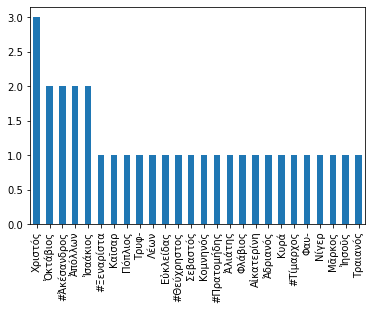

In [53]:
names_df.id.value_counts().plot(kind='bar', figsize=(6,4))

In [40]:
# most frequently occurring
names_df.id.value_counts().max()

3

In [42]:
# least frequently occurring
names_df.id.value_counts().min()

1

All name surface forms are quite unique:

In [43]:
names_df.surface.value_counts().mean()

1.03125

If we look at names ids, we can see that in average each name occur roughly 1.2 times:

In [46]:
names_df.id.value_counts().mean()

1.2307692307692308

In [92]:
names_df.id.value_counts().median()

1.0

And 75% of the names occur only once:

In [48]:
names_df.id.value_counts().describe()

count    26.000000
mean      1.230769
std       0.514408
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: id, dtype: float64

# Exercise


- You are asked to write a simple python program by modifying the code we provided in notebook `Pandas_BeautifulSoup.ipynb`, section "XML data → `DataFrame`"; the current code looks for `<name>` element and creates a `DataFrame` out of it. For the exercise you are asked to do something similar, but for a different set of TEI/EpiDoc elements of your choice.
- These are the steps to follow:
    1)  to identify one or more TEI elements of interest (can be lemmata, variants, bibliographic elements, metadata, etc.); 
    2)  to specify what information you to retain from them, and extract it from the XML (via `BeautifulSoup`) by modifying the code provided;
    3) convert it to a `pandas.DataFrame` and explore some statistics (for example by using `value_counts()`).


In [54]:
# put your code here